## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [23]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [2]:
# check shape
train_data.shape

(84534, 10)

In [3]:
# check NaNs
train_data.isna().sum()

ID           0
Promotion    0
purchase     0
V1           0
V2           0
V3           0
V4           0
V5           0
V6           0
V7           0
dtype: int64

In [4]:
# check info
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
ID           84534 non-null int64
Promotion    84534 non-null object
purchase     84534 non-null int64
V1           84534 non-null int64
V2           84534 non-null float64
V3           84534 non-null float64
V4           84534 non-null int64
V5           84534 non-null int64
V6           84534 non-null int64
V7           84534 non-null int64
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


In [5]:
# check summary
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


1. V1 looks like it has 3 categories
2. V2 is a continous positive variable
3. V3 is also continous but it has a minimum negative value
4. V4 has 2 categories
5. V5 has 5 categories
6. V6 has 4 categories
7. V7 has 2 categories

In [37]:
# change promotion from categorical to int
train_data = train_data.replace({"Yes": 1, "No": 0})

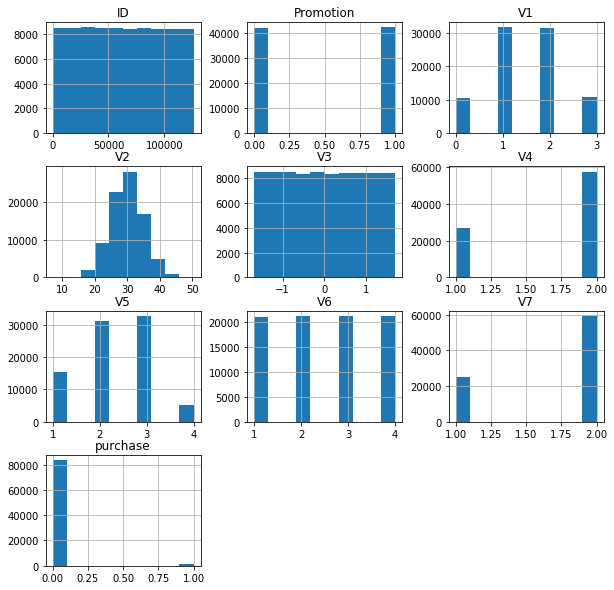

In [7]:
# visualize variables
train_data.hist(figsize=(10, 10));

V2 is normal, while V3 is uniform.

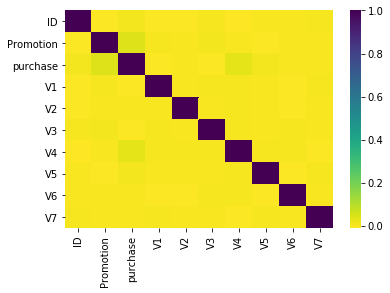

In [8]:
# visualize correlation
sb.heatmap(train_data.corr(), cmap="viridis_r");

Looks like there is a slight correlation between V4 and purchase. Let's isolate treatment group and look further.

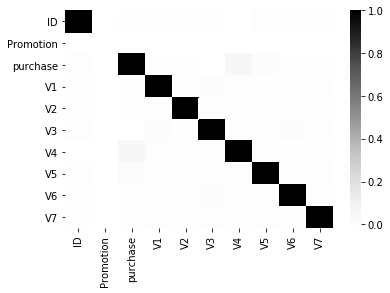

In [9]:
sb.heatmap(train_data.query("Promotion == 1").corr(), cmap="Greys");

The correlation appears to be present, so let's now look at the opposite.

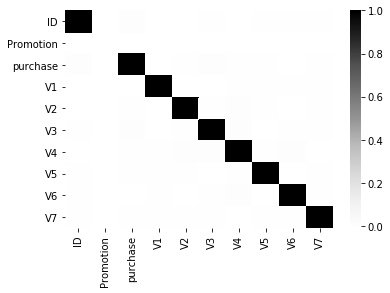

In [10]:
sb.heatmap(train_data.query("Promotion == 0").corr(), cmap="Greys");

There seems to be no correlation whatsoever. So there must be something different between the distribution of this feature among the treatment and control group.

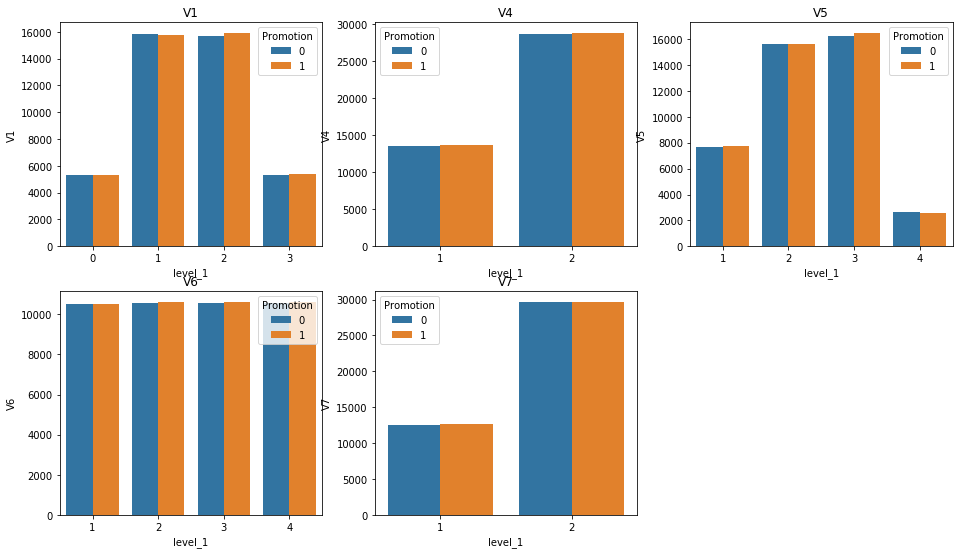

In [18]:
cat_cols = ['V'+i for i in '14567']
plt.figure(figsize=(16, 14))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(3, 3, i)
    group_col_count = train_data.groupby("Promotion")[col].apply(lambda x: x.value_counts()).reset_index()
    sb.barplot(data=group_col_count, x="level_1", y=col, hue="Promotion")
    plt.title(col)

Both groups have equal distributions of all categorical features, so how is that V4 is correlated with purchases in treatment only? Let's further investigate this phenomenon.

In [68]:
def plot_feature_purchase(feature):
    """visualize bar plot of purchases for treatment and control groups with different feature values"""
    plt.figure(figsize=(12, 4));
    plt.title(feature)
    for i in [0, 1]:
        plt.subplot(1, 2, i+1)
        plt.title(f"{feature}: Promotion == {i}")
        tmp = train_data.query("Promotion == @i").groupby(feature)["purchase"].value_counts().reset_index(name="count")
        sb.barplot(data=tmp, x=feature, y="count", hue="purchase") 

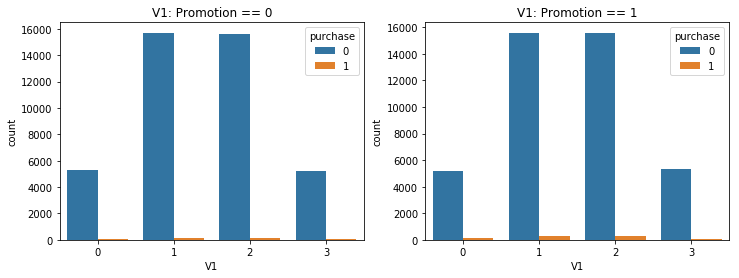

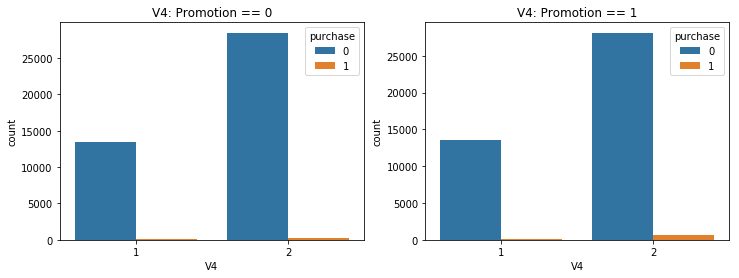

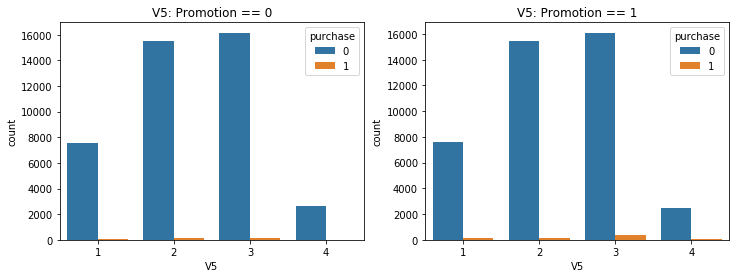

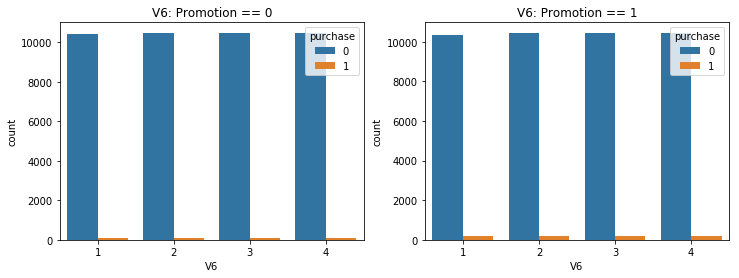

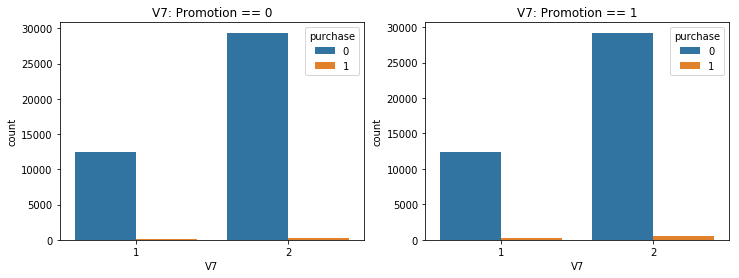

In [69]:
for col in cat_cols:
    plot_feature_purchase(col)

We can see that each feature have a slightly different distribution specifically with customers who recieved the promotion and made the purchase.

### Statisitcal Significance of Test Results

The statistical significance will test the difference in purchase rate and will be calculated using simulation.

In [120]:
# calculate different rates
purchase_rates = train_data.groupby("Promotion")["purchase"].value_counts()
ctrl_rate = purchase_rate[0][1]/purchase_rate[0].sum()
exp_rate = purchase_rate[1][1]/purchase_rate[1].sum()
null_rate = train_data.query("purchase == 1").shape[0] / train_data.shape[0]

# calculate counts
ctrl_count = train_data.query("Promotion == 0").shape[0]
exp_count = train_data.query("Promotion == 1").shape[0]

# calculate observed difference
obs_diff = exp_rate - ctrl_rate

# simulate purchases for customers using null rate
n_trials = 500_000
ctrl_samples = np.random.binomial(ctrl_count, null_rate, n_trials)
exp_samples = np.random.binomial(exp_count, null_rate, n_trials)
samples_diff = exp_samples / exp_count - ctrl_samples / ctrl_count

# calculate p-value based on one-tailed test
print("Observed IRR:", obs_diff)
print("P-Value:", np.mean(samples_diff >= obs_diff))

Observed IRR: 0.00945454781977
P-Value: 0.0


We can see that the p-value is so small, and there is no way that these results where due to randmoness.

### Practical Significance of Results
The practical significance will be based on net incremental revenue, which is based on sales of product specifically to treatment group excluding the promotion costs and sales to control group.

In [96]:
def calculate_nir(exp_purchase, exp_count, ctrl_purchase, price=10, cost=0.15):
    """Function to calculate net incremental value of product."""
    return (exp_purchase*price - exp_count*cost) - ctrl_purchase*price

In [117]:
# calculate different rates
purchase_count = train_data.groupby("Promotion")["purchase"].value_counts()
ctrl_rate = purchase_count[0][1]/purchase_count[0].sum()
exp_rate = purchase_count[1][1]/purchase_count[1].sum()
null_rate = train_data.query("purchase == 1").shape[0] / train_data.shape[0]

# calculate counts
ctrl_count = train_data.query("Promotion == 0").shape[0]
exp_count = train_data.query("Promotion == 1").shape[0]

# calculate observed net incremental revenus
obs_nir = calculate_nir(purchase_count[1][1], exp_count, purchase_count[0][1])

# simulate purchases for customers using null rate
n_trials = 500_000
ctrl_samples = np.random.binomial(ctrl_count, null_rate, n_trials)
exp_samples = np.random.binomial(exp_count, null_rate, n_trials)

samples_nir = []
for exp_purchase, ctrl_purchase in zip(exp_samples, ctrl_samples):
    samples_nir.append(calculate_nir(exp_purchase, exp_count, ctrl_purchase))

# calculate p-value based on one-tailed test
print("Obsereved NIR:", obs_nir)
print("P value:", np.mean(samples_nir >= obs_nir))

Obsereved NIR: -2334.6
P value: 0.0


Even though the results are statistically significance, but it seems that the net incremental value is negative, indicating that the promotion might not have been worthwhile due to the promotion costs.

This indicates that the promotion can be useful if we have a way to select the users who will recieve the promotion, and that is why we need to build a model that can predict the users who will purchase only if when they recieve the promotion.

Therefore we should be training on users who received the promotion only as a starter to test, and engineer the labels to be Yes for users who purchased, and no for users who didn't.

Also we can train the model to maximize the metrics that we have which are incremental response rate, and net incremental revenue.

### To be continued...

In [ ]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    
    
    
    return promotion

In [ ]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)